part 2

In this part of the assignment, we are required to design a CUDA accelerated kernal which could performs a equivalent mapping, as matrix A, of Laplace operator on an one-dimension array of $u_{i,j}$.

If the point is on the boundary/edge of the grid, the mapping will just keep its original value. If the point is inside the grid, an interior point, the mapping will perform like: $u_{i,j} \rightarrow \frac{4u_{i,j}-u_{i-1,j}-u_{i+1,j}-u_{i,j+1}}{h^2}$


This code section just contains some initial settings and a sample code which will be used to verify the realiability of out kernal.

In [1]:
import numpy as np
from scipy.sparse import coo_matrix
import numba
from numba import cuda
import time

import matplotlib
from matplotlib import pyplot as plt
from matplotlib.colors import LogNorm

# timer class is used to measure the time performance of our algorithm
class Timer:    
    def __enter__(self):
        self.start = time.time()
        return self
    def __exit__(self, *args):
        self.end = time.time()
        self.interval = self.end - self.start


def discretise_poisson(N):
    """Generate the matrix and rhs associated with the discrete Poisson operator."""
    
    nelements = 5 * N**2 - 16 * N + 16
    
    row_ind = np.empty(nelements, dtype=np.float64)
    col_ind = np.empty(nelements, dtype=np.float64)
    data = np.empty(nelements, dtype=np.float64)
    
    f = np.empty(N * N, dtype=np.float64)
    
    count = 0
    for j in range(N):
        for i in range(N):
            if i == 0 or i == N - 1 or j == 0 or j == N - 1:
                row_ind[count] = col_ind[count] = j * N + i
                data[count] =  1
                f[j * N + i] = 0
                count += 1
                
            else:
                row_ind[count : count + 5] = j * N + i
                col_ind[count] = j * N + i
                col_ind[count + 1] = j * N + i + 1
                col_ind[count + 2] = j * N + i - 1
                col_ind[count + 3] = (j + 1) * N + i
                col_ind[count + 4] = (j - 1) * N + i
                                
                data[count] = 4 * (N - 1)**2
                data[count + 1 : count + 5] = - (N - 1)**2
                f[j * N + i] = 1
                
                count += 5
                                                
    return coo_matrix((data, (row_ind, col_ind)), shape=(N**2, N**2)).tocsr(), f



The kernal follows the stages:
* load the data into device
* within each thread check the position of point
* perform mapping (kernel)
* return the result

In [2]:
@cuda.jit
def mat_A_cuda(u, res):
    local_u = cuda.shared.array((SX, SY), numba.float64)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y

    px, py = cuda.grid(2)

    if px >= n or py >=  n:
        return
  
    #boundary case
    if px == 0 or px == n-1 or py == 0 or py == n-1:
        res[px*n+py]=u[px*n+py]
    #interior case
    else:
        res[px*n+py]=(n-1)**2*(4*u[px*n+py]-u[(px-1)*n+py]-u[(px+1)*n+py]-u[px*n+py+1]-u[px*n+py-1])


In [3]:
# we set the number of points over the grid is 200 along each axis
n = 200
# for the purpose of demonstration u is an array filled with random value with random seed 0
u = np.random.RandomState(0).rand(n*n).astype("float64")

SX = 32
SY = 32

block_rows = (n + 31) // SX
block_cols = (n + 31) // SY

# res = np.zeros(u.shape, dtype=np.float64)
res_cuda = numba.cuda.device_array(n*n, dtype=np.float64)
u_cuda = numba.cuda.to_device(u)



mat_A_cuda[(block_rows, block_cols), (SX, SY)](u_cuda, res_cuda)
res_cuda = res_cuda.copy_to_host()

u_cuda = u_cuda.copy_to_host()

We can verify the correctness of our kernal just by comparing its output with the value of $A*u$ in which $A$ is the associated matrix generated for the possion problem.

In [4]:
A, _ = discretise_poisson(n)
u = np.random.RandomState(0).rand(n*n).astype("float64")
res_sample = A @ u
max_diff = np.max(abs(res_cuda - res_sample))
print("the maximum difference between CUDA and sample method is ", max_diff)

the maximum difference between CUDA and sample method is  5.820766091346741e-11


The difference is about $2^{-34}$ which lies between single and double precision.

or via a more formal/mathematical way

In [5]:
res_sample = A @ u
rel_error = np.linalg.norm(res_sample - res_cuda, np.inf) / np.linalg.norm(res_sample, np.inf)
print(f"Error: {round(rel_error, 2)}.")

Error: 0.0.


In [6]:

n = 200
# thread per grid
tpb = 1024
# number of block
nob = (len(u) + 1023) // 1024
rec = list()

# just change lim_h to a lower value if the current setting runs out of memory in your environment
lim_h = 12000
lim_l = 2000
lim_i = 2000

for n in range(lim_l, lim_h, lim_i):
    u = np.random.RandomState(0).rand(n*n).astype("float64")
    # res = np.zeros(u.shape, dtype=np.float64)
    print(n)
    with Timer() as t_data:
        u_cuda = numba.cuda.to_device(u)
        res_cuda = numba.cuda.device_array(u.shape, dtype=np.float64)
    print("data transfer takes, {0:.5f} seconds, n = {a}".format(t_data.interval, a=n))
    with Timer() as t_cal:
        mat_A_cuda[nob, tpb](u_cuda, res_cuda)
    print("calculation takes, {0:.5f} seconds, n = {a}".format(t_cal.interval, a=n))
    with Timer() as t_back:
        res_cuda = res_cuda.copy_to_host()
    print("data back takes, {0:.5f} seconds, n = {a}".format(t_back.interval, a=n))
    u_cuda = u_cuda.copy_to_host()
    rec.append({"n":n,"t_data":t_data.interval,"t_cal":t_cal.interval})



2000
data transfer takes, 0.00798 seconds, n = 2000
calculation takes, 0.00000 seconds, n = 2000
data back takes, 0.00897 seconds, n = 2000
4000
data transfer takes, 0.03591 seconds, n = 4000
calculation takes, 0.00096 seconds, n = 4000
data back takes, 0.03793 seconds, n = 4000
6000
data transfer takes, 0.08480 seconds, n = 6000
calculation takes, 0.00100 seconds, n = 6000
data back takes, 0.08375 seconds, n = 6000
8000
data transfer takes, 0.16356 seconds, n = 8000
calculation takes, 0.00100 seconds, n = 8000
data back takes, 0.15259 seconds, n = 8000
10000
data transfer takes, 0.26629 seconds, n = 10000
calculation takes, 0.00000 seconds, n = 10000
data back takes, 0.24238 seconds, n = 10000


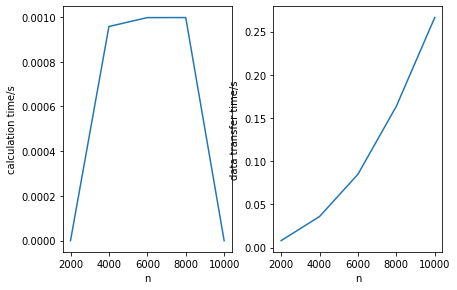

In [7]:
fig, _ = plt.subplots(1,2)
fig.tight_layout() 
axs1 = plt.subplot(1, 2, 1)
axs1.plot([temp["n"] for temp in rec], [temp["t_cal"] for temp in rec])
axs1.set_xlabel("n")
axs1.set_ylabel("calculation time/s")
axs1 = plt.subplot(1, 2, 2)
axs1.plot([temp["n"] for temp in rec], [temp["t_data"] for temp in rec])
axs1.set_xlabel("n")
axs1.set_ylabel("data transfer time/s")
plt.show()

The calculation time does not change significantly wrt n. There is a quadratic relationship between n and time for data transfer, which result from that the fact number of elements in u = $u^2$ 

Before we move on to the shared memory strategy. We would like to 

Our pervious kernal with 1d grid is (sadly) not intuitive for the shared memory strategy. It is better to redesign the kernal with 2D input.
* the shared memory is designed to be a (34, 34) matrix to contain all the information of u in local blocks and their adjacent points.
Thread in each block could only access the (34, 34) shared memory to calculate the linear map. Thus there is no need to continually access the slow global memory. However, since the shared memory stores duplicate datas, it might decrease the max n we could calculate.
The implementation of the shared memory method is as follows.

In [8]:
@cuda.jit
def mat_A_cuda_shared(u, res):
    local_u = cuda.shared.array((34, 34), numba.float64)

    tx = cuda.threadIdx.x
    ty = cuda.threadIdx.y
    
    px, py = cuda.grid(2)

    if px>=n or py >=n:
        return

    
    local_u[tx+1, ty+1] = u[px, py]

    # transfer the local u to a 34*34 shared memory local_u
    if tx == 0:
        #if px != 0: not necessary since thread will just do nothing if out of boundary
        local_u[tx, ty+1] = u[px-1, py]
    if tx == SX-1:
        #if px != n-1:
        local_u[tx+2, ty+1] = u[px+1, py]
    if ty == 0:
        #if py != 0:
        local_u[tx+1, ty] = u[px, py-1]
    if ty == SY-1:
        #if py != n-1:
        local_u[tx+1, ty+2] = u[px, py+1]

    cuda.syncthreads()    
    #boundary case
    if px == 0 or px == n-1 or py == 0 or py == n-1:
        res[px, py] = local_u[tx+1, ty+1]
    #interior case
    else:
        res[px, py]=(4*local_u[tx+1,ty+1]-local_u[tx, ty+1]-local_u[tx+2, ty+1]-local_u[tx+1, ty]-local_u[tx+1, ty+2])*(n-1)**2


In [9]:
# we set the number of points over the grid is 200 along each axis
n = 200
# for the purpose of demonstration u is an array filled with random value with random seed 0
u = np.random.RandomState(0).rand(n*n).reshape(n,n).astype("float64")
SX = 32
SY = 32
block_rows = (n + 31) // SX
block_cols = (n + 31) // SY

# res = np.zeros(u.shape, dtype=np.float64)
res_cuda = numba.cuda.device_array(u.shape, dtype=np.float64)
u_cuda = numba.cuda.to_device(u.reshape(n,n))


mat_A_cuda_shared[(block_rows, block_cols),(SX, SY)](u_cuda, res_cuda)
res_cuda = res_cuda.reshape(n*n).copy_to_host()

u_cuda = u_cuda.copy_to_host()

In [10]:
A, _ = discretise_poisson(n)
u = np.random.RandomState(0).rand(n*n).astype("float64")
res_sample = A @ u
max_diff = np.max(abs(res_cuda - res_sample))
print("the maximum difference between CUDA and sample method is ", max_diff)

the maximum difference between CUDA and sample method is  5.820766091346741e-11


Our shared method produce the exact same result of non-shared method, which is obvious. Unfortunately my GPU memory is to small to store a u which is sufficiently big to have a comparable calculation time (they are almost 0 in all cases). Thus trying to compare the performance of shared and non-shared method might be trivial.

2000
data transfer takes, 0.00799 seconds, n = 2000
calculation takes, 0.00096 seconds, n = 2000
data back takes, 0.00997 seconds, n = 2000
4000
data transfer takes, 0.03391 seconds, n = 4000
calculation takes, 0.00000 seconds, n = 4000
data back takes, 0.05982 seconds, n = 4000
6000
data transfer takes, 0.08973 seconds, n = 6000
calculation takes, 0.00000 seconds, n = 6000
data back takes, 0.08780 seconds, n = 6000
8000
data transfer takes, 0.16752 seconds, n = 8000
calculation takes, 0.00100 seconds, n = 8000
data back takes, 0.15960 seconds, n = 8000
10000
data transfer takes, 0.25731 seconds, n = 10000
calculation takes, 0.00000 seconds, n = 10000
data back takes, 0.23537 seconds, n = 10000


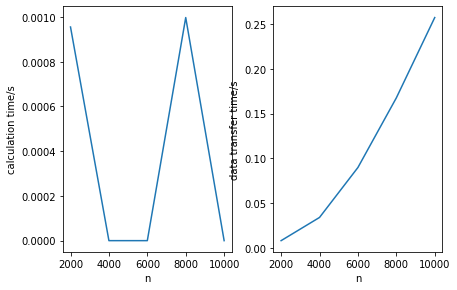

In [11]:
n = 200

SX = 32
SY = 32
block_rows = (n + 31) // SX
block_cols = (n + 31) // SY



nob = (len(u) + 1023) // 1024
rec = list()

# just change lim_h to a lower value if the current setting runs out of memory in your environment
lim_h = 12000
lim_l = 2000
lim_i = 2000


for n in range(lim_l, lim_h, lim_i):
    u = np.random.RandomState(0).rand(n,n).astype("float64")
    # res = np.zeros(u.shape, dtype=np.float64)
    print(n)
    with Timer() as t_data:
        u_cuda = numba.cuda.to_device(u)
        res_cuda = numba.cuda.device_array(u.shape, dtype=np.float64)
    print("data transfer takes, {0:.5f} seconds, n = {a}".format(t_data.interval, a=n))
    with Timer() as t_cal:
        mat_A_cuda_shared[(block_rows, block_cols),(SX, SY)](u_cuda, res_cuda)
    print("calculation takes, {0:.5f} seconds, n = {a}".format(t_cal.interval, a=n))
    with Timer() as t_back:
        res_cuda = res_cuda.copy_to_host()
    print("data back takes, {0:.5f} seconds, n = {a}".format(t_back.interval, a=n))
    u_cuda = u_cuda.copy_to_host()
    rec.append({"n":n,"t_data":t_data.interval,"t_cal":t_cal.interval})

fig, _ = plt.subplots(1,2)
fig.tight_layout() 
axs1 = plt.subplot(1, 2, 1)
axs1.plot([temp["n"] for temp in rec], [temp["t_cal"] for temp in rec])
axs1.set_xlabel("n")
axs1.set_ylabel("calculation time/s")
axs1 = plt.subplot(1, 2, 2)
axs1.plot([temp["n"] for temp in rec], [temp["t_data"] for temp in rec])
axs1.set_xlabel("n")
axs1.set_ylabel("data transfer time/s")
plt.show()